>作者: 小猴子
>
>公众号: 机器学习研习院

本文旨在使用 XGBoost、随机森林、KNN、逻辑回归、SVM 和决策树解决分类问题


## 案例简介
假设你受雇于帮助一家信用卡公司检测潜在的欺诈案件，你的工作是确保客户不会因未购买的商品而被收取费用。给你一个包含人与人之间交易的数据集，他们是欺诈与否的信息，并要求你区分它们。我们的最终目的是通过构建分类模型来对欺诈交易进行分类区分来解决上述情况。


<br>

## 本文结构
- 导入所需模块到 python 环境中
- 读取数据
- 探索性数据分析及数据预处理
- 特征选择和数据集拆分
- 构建六类分类模型
- 使用评估指标评估创建的分类模型

<br>

对于这个案例，所需要用到的主要模块是处理数据的 Pandas、处理数组的 NumPy、用于数据拆分、构建和评估分类模型的 scikit-learn，最后是用于 xgboost 分类器模型算法的 xgboost 包。

<br>

## 导入数据
关于数据： 我们将要使用的数据是 **Kaggle 信用卡欺诈检测数据集**。它包含特征 V1 到 V28，是 PCA 获得的主要成分，并忽略对构建模型没有用的时间特征。其余的特征是包含交易总金额的"金额"特征和包含交易是否为欺诈案件的"类别"特征。

现在使用'pd.read_csv'方法导入数据，并查看部分数据样例。

Kaggle 信用卡欺诈检测数据集: https://www.kaggle.com/mlg-ulb/creditcardfraud

In [2]:
import pandas as pd

df = pd.read_csv('creditcard.csv')
df.drop('Time', axis = 1, inplace = True)

df.head()

V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       V21       V22       V23       V24  \
0  0.098698  0.363787  0.090794  ... -0.018307  0.277838 -0.110474  0.066928   
1  0.085102 -0.255425 -0.166974  ... -0.225775 -0.638672  0.101288 -0.339846   
2  0.247676 -1.514654  0.207643  ...  0.247998  0.771679  0.909412 -0.689281   
3  0.377436 -1.387024 -0.054952  ... -0.108300  0.005274 -0.190321 -1.175575   
4 -0.270533  0.817739  0.753074  ... -0.009431  0.798278 -0.137458  0.141267   

        V25       V26       V27       V28  Amount  Class  
0  0.128539 -0.189115  0.133558 -0.021053  149.62      0  
1  0.167170  0.125895 -0.008983  0.014724    2.69      0  
2 -0.327642 -0.139097 -0.055353 -0.059752  378.66      0  
3  0.647376 -0.221929  0.062723  0.061458  123.50      0  
4 -0.206010  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 30 columns]



接下来将进行一些数据预处理和探索性数据分析（EDA）。

<br>

## 探索性数据分析
看看数据集中有多少欺诈案件和非欺诈案件。此外，还计算整个记录交易中欺诈案件的百分比。

In [4]:
from termcolor import colored as cl

cases = len(df)
nonfraud_count = len(df[df.Class == 0])
fraud_count = len(df[df.Class == 1])
fraud_percentage = round(fraud_count/nonfraud_count*100, 2)

print(cl('CASE COUNT', attrs = ['bold']))
print(cl('--------------------------------------------', attrs = ['bold']))
print(cl('Total number of cases are {}'.format(cases), attrs = ['bold']))
print(cl('Number of Non-fraud cases are {}'.format(nonfraud_count), attrs = ['bold']))
print(cl('Number of Non-fraud cases are {}'.format(fraud_count), attrs = ['bold']))
print(cl('Percentage of fraud cases is {}'.format(fraud_percentage), attrs = ['bold']))
print(cl('--------------------------------------------', attrs = ['bold']))

CASE COUNT
--------------------------------------------
Total number of cases are 284807
Number of Non-fraud cases are 284315
Number of Non-fraud cases are 492
Percentage of fraud cases is 0.17
--------------------------------------------


我们可以看到，在 **284,807** 个样本中，只有 **492** 个欺诈案例，仅占样本总数的 **0.17%** 。所以，可以说我们正在处理的数据是高度不平衡的数据，需要在建模和评估时谨慎处理。

接下来，我们将使用 Python 中的**"describe"**方法获取欺诈和非欺诈交易金额数据的统计视图。

In [5]:
nonfraud_cases = df[df.Class == 0]
fraud_cases = df[df.Class == 1]

print(cl('CASE AMOUNT STATISTICS', attrs = ['bold']))
print(cl('--------------------------------------------', attrs = ['bold']))
print(cl('NON-FRAUD CASE AMOUNT STATS', attrs = ['bold']))
print(nonfraud_cases.Amount.describe())
print(cl('--------------------------------------------', attrs = ['bold']))
print(cl('FRAUD CASE AMOUNT STATS', attrs = ['bold']))
print(fraud_cases.Amount.describe())
print(cl('--------------------------------------------', attrs = ['bold']))

CASE AMOUNT STATISTICS
--------------------------------------------
NON-FRAUD CASE AMOUNT STATS
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64
--------------------------------------------
FRAUD CASE AMOUNT STATS
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64
--------------------------------------------


在查看统计数据时，可以看到与其余变量相比，"**金额**" 变量中的值变化很大。为了减少其广泛的值，我们可以使用 python 中的 "**StandardScaler()**" 方法对其进行标准化。

In [15]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
amount = df['Amount'].values

df['Amount'] = sc.fit_transform(amount.reshape(-1, 1))

print(cl(df['Amount'].head(10), attrs = ['bold']))

0    0.244964
1   -0.342475
2    1.160686
3    0.140534
4   -0.073403
5   -0.338556
6   -0.333279
7   -0.190107
8    0.019392
9   -0.338516
Name: Amount, dtype: float64


<br>

## 特征选择和数据集拆分
在这个过程中，定义自变量 (X) 和因变量 (Y)。使用定义的变量将数据分成训练集和测试集，进一步用于建模和评估。可以使用 python 中的 "**train_test_split**" 算法轻松拆分数据。

In [16]:
from sklearn.model_selection import train_test_split
# DATA SPLIT

X = df.drop('Class', axis = 1).values
y = df['Class'].values

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.2, random_state = 0)

print(cl('X_train samples : ', attrs = ['bold']),
      X_train[:1])
print(cl('X_test samples : ', attrs = ['bold']),
      X_test[0:1])
print(cl('y_train samples : ', attrs = ['bold']),
      y_train[0:20])
print(cl('y_test samples : ', attrs = ['bold']),
      y_test[0:20])

X_train samples :  [[-1.11504743  1.03558276  0.80071244 -1.06039825  0.03262117  0.85342216
  -0.61424348 -3.23116112  1.53994798 -0.81690879 -1.30559201  0.1081772
  -0.85960958 -0.07193421  0.90665563 -1.72092961  0.79785322 -0.0067594
   1.95677806 -0.64489556  3.02038533 -0.53961798  0.03315649 -0.77494577
   0.10586781 -0.43085348  0.22973694 -0.0705913  -0.30145418]]
X_test samples :  [[-0.32333357  1.05745525 -0.04834115 -0.60720431  1.25982115 -0.09176072
   1.1591015  -0.12433461 -0.17463954 -1.64440065 -1.11886302  0.20264731
   1.14596495 -1.80235956 -0.24717793 -0.06094535  0.84660574  0.37945439
   0.84726224  0.18640942 -0.20709827 -0.43389027 -0.26161328 -0.04665061
   0.2115123   0.00829721  0.10849443  0.16113917 -0.19330595]]
y_train samples :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
y_test samples :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


到目前为止，已经做好了构建分类模型所需的所有准备。

<br>

## 模型建立
这里构建六种不同类型的分类模型，即**决策树、K-最近邻 (KNN)、逻辑回归、支持向量机 (SVM)、随机森林和 XGBoost**。虽然我们还可以使用更多其他的模型，但我们选用的是用于解决分类问题的最流行模型。所有这些模型构建均比较方便，都可以使用 **scikit-learn** 包提供的算法来构建。仅对于 XGBoost 模型，将使用 xgboost 包。接下来在 python 中实现这些模型，所使用的算法可能需要花费一定的时间来实现。



In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


# MODELING

# 1. Decision Tree
tree_model = DecisionTreeClassifier(max_depth = 4, criterion = 'entropy')
tree_model.fit(X_train, y_train)
tree_yhat = tree_model.predict(X_test)

# 2. K-Nearest Neighbors
n = 5
knn = KNeighborsClassifier(n_neighbors = n)
knn.fit(X_train, y_train)
knn_yhat = knn.predict(X_test)

# 3. Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_yhat = lr.predict(X_test)

# 4. SVM 
svm = SVC()
svm.fit(X_train, y_train)
svm_yhat = svm.predict(X_test)

# 5. Random Forest Tree
rf = RandomForestClassifier(max_depth = 4)
rf.fit(X_train, y_train)
rf_yhat = rf.predict(X_test)

# 6. XGBoost
xgb = XGBClassifier(max_depth = 4)
xgb.fit(X_train, y_train)
xgb_yhat = xgb.predict(X_test)

至此我们构建了从决策树模型到 XGBoost 模型的六种不同类型的分类模型。

在决策树模型中，使用 **"DecisionTreeClassifier"** 算法来构建模型。在算法中，设置 **"max_depth=4"**，意味着允许树最大分裂四次，**"criterion = 'entropy"**，与**"max_depth"**最相似，但决定何时分裂停止分裂树。最后拟合模型后将预测值存储到 **"tree_yhat"** 变量中。

在K-最近邻 (KNN)中，使用 **"KNeighborsClassifier"** 算法构建了模型，并设置 **"n_neighbors=5"**。 **'n_neighbors'** 的值是随机选择的，其实可以通过迭代一系列值来有目的地选择，然后拟合模型后将预测值存储到 **"knn_yhat"** 变量中。

逻辑回归的代码没有什么可解释的，因为我使用 **"LogisticRegression"** 算法并全部使用默认值，并拟合模型后将预测值存储到 **"lr_yhat"** 变量中。

使用"SVC"算法构建了支持向量机模型，并且同样使用默认值，并且默认内核就是我们所希望用到的模型，即"rbf"内核。之后，我们在拟合模型后将预测值存储到 "svm_yhat" 中。

接下来使用 **"RandomForestClassifier"** 算法构建的随机森林模型，设置参数 **"max_depth=4"**，就像构建决策树模型的方式一样。最后在拟合模型后将预测值存储到 **"rf_yhat"** 中。请记住，决策树和随机森林之间的主要区别在于，决策树使用整个数据集来构建单个模型，而随机森林使用随机选择的特征来构建多个模型。这就是为什么很多情况下选择使用随机森林模型而不是决策树的原因。

最后是 XGBoost 模型。使用 xgboost 包提供的 **"XGBClassifier"** 算法构建模型。设置 **"max_depth=4"**，最后在拟合模型后将预测值存储到 "xgb_yhat" 中。

至此，我们成功构建了六种分类模型，为了便于理解，对代码进行了简单解释。接下来需要评估每个模型，并找到最适合我们案例的模型。




<br>

## 模型评估
之前有提到过，我们将使用 scikit-learn 包提供的评估指标来评估我们构建的模型。在此过程中的主要目标是为给定案例找到最佳模型。这里将使用的评估指标是**准确度评分指标、f1 评分指标，及混淆矩阵**。

### 准确率
准确率是最基本的评价指标之一，广泛用于评价分类模型。准确率分数的计算方法很简单，就是将模型做出的正确预测的数量除以模型做出的预测总数（可以乘以 100 将结果转换为百分比）。一般可以表示为：

**准确度分数 = 正确预测数 / 总预测数**

我们检查我们所构建的六种不同分类模型的准确率分数。要在 python 中完成，我们可以使用 scikit-learn 包提供的 **"accuracy_score"** 方法。

In [19]:
from sklearn.metrics import accuracy_score

# 1. Accuracy score
print(cl('ACCURACY SCORE', attrs = ['bold']))
print(cl('Accuracy score of the Decision Tree model is {}'
         .format(accuracy_score(y_test, tree_yhat)),
         attrs = ['bold']))
print(cl('Accuracy score of the KNN model is {}'
         .format(accuracy_score(y_test, knn_yhat)),
         attrs = ['bold'], color = 'green'))
print(cl('Accuracy score of the Logistic Regression model is {}'
         .format(accuracy_score(y_test, lr_yhat)),
         attrs = ['bold'], color = 'red'))
print(cl('Accuracy score of the SVM model is {}'
         .format(accuracy_score(y_test, svm_yhat)),
         attrs = ['bold']))
print(cl('Accuracy score of the Random Forest Tree model is {}'
         .format(accuracy_score(y_test, rf_yhat)),
         attrs = ['bold']))
print(cl('Accuracy score of the XGBoost model is {}'
         .format(accuracy_score(y_test, xgb_yhat)), 
         attrs = ['bold']))

ACCURACY SCORE
Accuracy score of the Decision Tree model is 0.9993679997191109
Accuracy score of the KNN model is 0.9995259997893332
Accuracy score of the Logistic Regression model is 0.9991924440855307
Accuracy score of the SVM model is 0.9993153330290369
Accuracy score of the Random Forest Tree model is 0.9993153330290369
Accuracy score of the XGBoost model is 0.9994908886626171


根据准确性评分评估指标来看，**KNN** 模型为最准确的模型，而 **Logistic** 回归模型最不准确。然而，当我们对每个模型的结果进行四舍五入时，得到 99% 的准确性，这看是一个非常好的分数。

### F1-score
F1-score 或 F-score 是用于评估分类模型的最流行的评估指标之一。它可以简单地定义为**模型的准确率和召回率的调和平均值**。它的计算方法是将 模型的精度和召回率的乘积除以模型的精度和召回率相加得到的值，最后乘以 2 得到的值。可以表示为：

**F1-score  = 2( (精度 * 召回率) / (精度 + 召回率) )**

可以使用 scikit-learn 包提供的 "f1_score" 方法轻松计算 **F1-score** 。

In [20]:
from sklearn.metrics import f1_score 

# 2. F1 score
print(cl('F1 SCORE', attrs = ['bold']))
print(cl('F1 score of the Decision Tree model is {}'
         .format(f1_score(y_test, tree_yhat)),
         attrs = ['bold']))
print(cl('F1 score of the KNN model is {}'
         .format(f1_score(y_test, knn_yhat)),
         attrs = ['bold'], color = 'green'))
print(cl('F1 score of the Logistic Regression model is {}'
         .format(f1_score(y_test, lr_yhat)),
         attrs = ['bold'], color = 'red'))
print(cl('F1 score of the SVM model is {}'
         .format(f1_score(y_test, svm_yhat)),
         attrs = ['bold']))
print(cl('F1 score of the Random Forest Tree model is {}'
         .format(f1_score(y_test, rf_yhat)),
         attrs = ['bold']))
print(cl('F1 score of the XGBoost model is {}'
         .format(f1_score(y_test, xgb_yhat)),
         attrs = ['bold']))

F1 SCORE
F1 score of the Decision Tree model is 0.8105263157894738
F1 score of the KNN model is 0.8571428571428572
F1 score of the Logistic Regression model is 0.7356321839080459
F1 score of the SVM model is 0.7771428571428572
F1 score of the Random Forest Tree model is 0.7796610169491525
F1 score of the XGBoost model is 0.8449197860962566


模型的排名几乎与之前的评估指标相似。在 F1-score 评估指标的基础上，KNN 模型再次夺得第一，Logistic 回归模型仍然是最不准确的模型。

### 混淆矩阵
通常，混淆矩阵是分类模型的可视化，显示模型与原始结果相比预测结果的程度。通常，预测结果存储在一个变量中，然后将其转换为相关表。使用相关表，以热图的形式绘制混淆矩阵。尽管有多种内置方法可以可视化混淆矩阵，但我们将从零开始定义和可视化它，以便更好地理解。

In [22]:
# 3. Confusion Matrix
# defining the plot function
def plot_confusion_matrix(cm, classes, title, normalize = False, cmap = plt.cm.Blues):
    title = 'Confusion Matrix of {}'.format(title)
    
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import itertools
    import numpy as np
    
    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix for the models

tree_matrix = confusion_matrix(y_test, tree_yhat, 
                labels = [0, 1]) # Decision Tree
knn_matrix = confusion_matrix(y_test, 
                knn_yhat, labels = [0, 1]) # K-Nearest Neighbors
lr_matrix = confusion_matrix(y_test, lr_yhat, 
                labels = [0, 1]) # Logistic Regression
svm_matrix = confusion_matrix(y_test, svm_yhat, 
                labels = [0, 1]) # Support Vector Machine
rf_matrix = confusion_matrix(y_test, rf_yhat, 
                labels = [0, 1]) # Random Forest Tree
xgb_matrix = confusion_matrix(y_test, xgb_yhat, 
                labels = [0, 1]) # XGBoost

# Plot the confusion matrix
plt.rcParams['figure.figsize'] = (6, 6)

### Decision tree

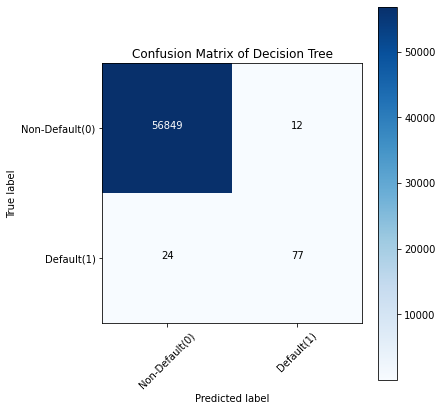

In [23]:
tree_cm_plot = plot_confusion_matrix(tree_matrix, 
                      classes = ['Non-Default(0)','Default(1)'], 
                      normalize = False, title = 'Decision Tree')
plt.savefig('tree_cm_plot.png')
plt.show()

### K-Nearest Neighbors

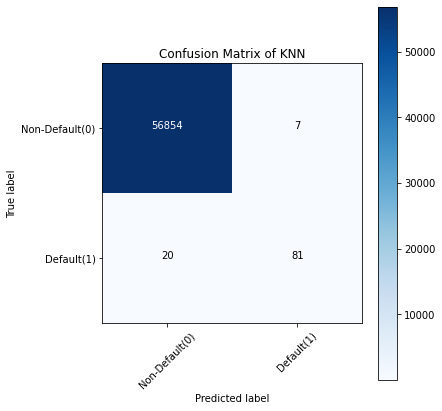

In [24]:
knn_cm_plot = plot_confusion_matrix(knn_matrix, 
                                classes = ['Non-Default(0)','Default(1)'], 
                                normalize = False, title = 'KNN')
plt.savefig('knn_cm_plot.png')
plt.show()

### Logistic regression

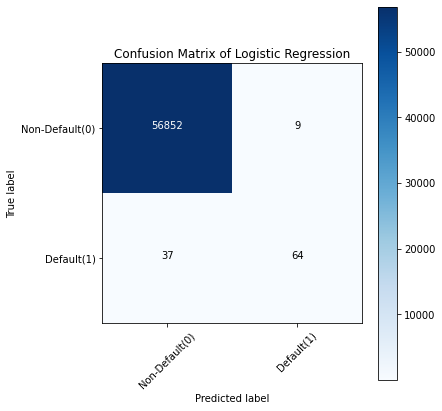

In [25]:
lr_cm_plot = plot_confusion_matrix(lr_matrix, 
                                classes = ['Non-Default(0)','Default(1)'], 
                                normalize = False, title = 'Logistic Regression')
plt.savefig('lr_cm_plot.png')
plt.show()

### Support Vector Machine

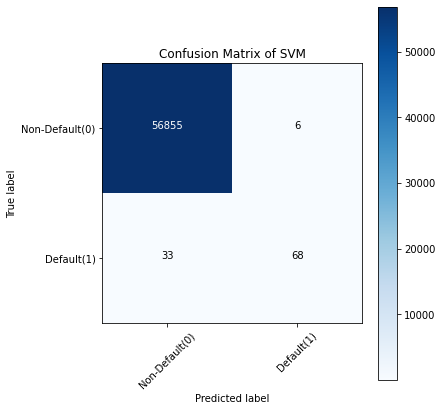

In [26]:
svm_cm_plot = plot_confusion_matrix(svm_matrix, 
                                classes = ['Non-Default(0)','Default(1)'], 
                                normalize = False, title = 'SVM')
plt.savefig('svm_cm_plot.png')
plt.show()

### Random Forest

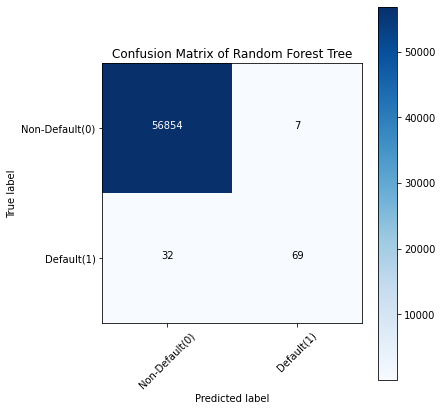

In [27]:
rf_cm_plot = plot_confusion_matrix(rf_matrix, 
                                classes = ['Non-Default(0)','Default(1)'], 
                                normalize = False, title = 'Random Forest Tree')
plt.savefig('rf_cm_plot.png')
plt.show()

### XGBoost

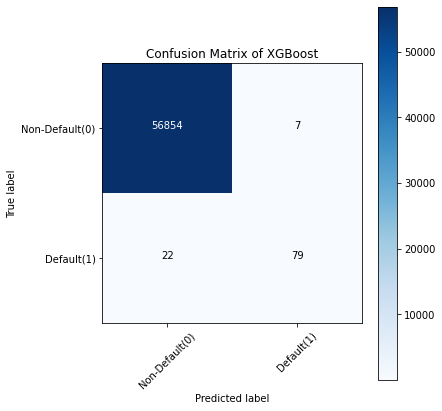

In [28]:
xgb_cm_plot = plot_confusion_matrix(xgb_matrix, 
                                classes = ['Non-Default(0)','Default(1)'], 
                                normalize = False, title = 'XGBoost')
plt.savefig('xgb_cm_plot.png')
plt.show()

**混淆矩阵理解**： 以XGBoost模型的混淆矩阵为例。

- 第一行。
第一行是测试集中实际欺诈值为0的交易。可以计算，其中56861笔欺诈值为0。在这56861笔非欺诈交易中，分类器正确预测了其中的56854笔为 0 和 预测了其中 7 为 1。这意味着，对于 56854 笔非欺诈交易，测试集中的实际流失值为 0，分类器也正确预测为 0。可以说我们的模型已经对非欺诈交易进行了分类交易还不错。

- 第二行。
看起来有 101 笔交易的欺诈值为 1。分类器正确预测其中 79 笔为 1，错误预测值为 0 的 22 笔。错误预测值可以视为模型的错误。

在比较所有模型的混淆矩阵时可以看出，K-Nearest Neighbors 模型在从非欺诈交易中分类欺诈交易方面做得非常好，其次是 XGBoost 模型。所以可以得出结论，最适合本次案例的模型是 **K-Nearest Neighbors** 模型，可以忽略的模型是 Logistic 回归模型。



<br>

## 写在最后
经过一连串的过程，我们已经成功构建了从决策树模型到XGBoost模型的六种不同类型的分类模型。随后使用评估指标评估了每个模型，并选择了最适合给定案例的模型。

在本文中，我们只选用了6个相对流行的模型，其实还有更多模型需要探索。此外，虽然我们很轻松地在 python 中可行地构建了模型，但是每个模型背后都有很多的数学和统计数据，在有精力的情况下，可以去了解下这么模型背后的数学推理。


## 参考资料
[1] Kaggle 信用卡欺诈检测数据集: https://www.kaggle.com/mlg-ulb/creditcardfraud

